In [2]:
import os, cv2, math, random, shutil
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

C:\Users\HP\anaconda3\envs\XAI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os, cv2, numpy as np
from tqdm import tqdm
import pandas as pd
from skimage import filters, morphology, measure


In [4]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

# -----------------------
# PATHS
# -----------------------
DATASET_DIR = r"C:\Users\HP\Documents\COVID-19_Radiography_Dataset"
save_dir = r"C:\Users\HP\Documents\processedCOVID-19_Radiography_Dataset"
classes = {
    "COVID": 1,
    "Normal": 0,
    "Viral Pneumonia": 0,
    "Lung_Opacity": 0
}

rows = []

for cls_name, label in classes.items():
    img_dir = os.path.join(DATASET_DIR, cls_name, "images")
    mask_dir = os.path.join(DATASET_DIR, cls_name, "masks")

    img_paths = glob.glob(os.path.join(img_dir, "*.png")) + \
                glob.glob(os.path.join(img_dir, "*.jpg")) + \
                glob.glob(os.path.join(img_dir, "*.jpeg"))

    for img_path in img_paths:
        fname = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, fname)

        if os.path.exists(mask_path):
            rows.append([img_path, mask_path, label])

# Build DataFrame
df = pd.DataFrame(rows, columns=["img_path", "mask_path", "label"])

print("Total samples:", len(df))
print(df.head())


Total samples: 21165
                                            img_path  \
0  C:\Users\HP\Documents\COVID-19_Radiography_Dat...   
1  C:\Users\HP\Documents\COVID-19_Radiography_Dat...   
2  C:\Users\HP\Documents\COVID-19_Radiography_Dat...   
3  C:\Users\HP\Documents\COVID-19_Radiography_Dat...   
4  C:\Users\HP\Documents\COVID-19_Radiography_Dat...   

                                           mask_path  label  
0  C:\Users\HP\Documents\COVID-19_Radiography_Dat...      1  
1  C:\Users\HP\Documents\COVID-19_Radiography_Dat...      1  
2  C:\Users\HP\Documents\COVID-19_Radiography_Dat...      1  
3  C:\Users\HP\Documents\COVID-19_Radiography_Dat...      1  
4  C:\Users\HP\Documents\COVID-19_Radiography_Dat...      1  


In [4]:
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df.label, random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.15, stratify=train_df.label, random_state=42)

print(len(train_df), len(val_df), len(test_df))


15291 2699 3175


In [5]:
import cv2
import numpy as np
from skimage.filters import frangi
from skimage.feature import local_binary_pattern

# ============================================================
# 1. CLAHE (unchanged)
# ============================================================
def apply_nclahe(img):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(img)
    cl = cv2.normalize(cl, None, 0, 255, cv2.NORM_MINMAX)
    return cl.astype(np.uint8)

# ============================================================
# 2. Bone suppression (unchanged)
# ============================================================
def bone_suppress(img):
    base = cv2.bilateralFilter(img, d=7, sigmaColor=30, sigmaSpace=30)
    detail = cv2.subtract(img, base)
    return cv2.add(base, (0.18 * detail).astype(np.uint8))

# ============================================================
# 3. Frequency enhancement (AFD)
# ============================================================
def frequency_enhance(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows//2, cols//2

    # mid-band mask
    r1, r2 = 15, 60
    mask = np.zeros((rows, cols), np.float32)

    for i in range(rows):
        for j in range(cols):
            d = np.sqrt((i-crow)**2 + (j-ccol)**2)
            if r1 < d < r2:
                mask[i, j] = 1.0

    filtered = fshift * mask
    img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered)))
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)

    return img_back.astype(np.uint8)

# ============================================================
# 4. Vessel enhancement (Frangi / Hessian)
# ============================================================
def vessel_enhance(img):
    v = frangi(img.astype(np.float64), scale_range=(1, 8))
    v = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)
    return v.astype(np.uint8)

# ============================================================
# 5. Texture enhancement (LBP)
# ============================================================
def texture_lbp(img):
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    lbp = cv2.normalize(lbp, None, 0, 255, cv2.NORM_MINMAX)
    return lbp.astype(np.uint8)

# ============================================================
# 6. FULL PREPROCESSING PIPELINE WITH LUNG MASK
# ============================================================
def preprocess_with_mask(img_path, mask_path, out_size=(512, 512)):
    img  = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        return None

    img  = cv2.resize(img,  out_size, interpolation=cv2.INTER_AREA)
    mask = cv2.resize(mask, out_size, interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.uint8)

    # Base enhancement
    img_base = apply_nclahe(img)
    img_base = bone_suppress(img_base)

    # Masked ROI
    roi = cv2.bitwise_and(img_base, img_base, mask=mask * 255)

    # --- Three advanced enhancements ---
    freq_img = frequency_enhance(roi)
    vessel_img = vessel_enhance(roi)
    lbp_img = texture_lbp(roi)

    # Final 4-channel output (H,W,4)
    final = np.stack([roi, freq_img, vessel_img, lbp_img], axis=-1)

    return final


In [6]:
import os
import csv
import numpy as np
from tqdm import tqdm

def save_split(df, split_name, save_root):
    """
    Preprocesses each sample using preprocess_with_mask(),
    then saves the 4-channel output as .npy files.
    """
    split_dir = os.path.join(save_root, split_name)
    os.makedirs(split_dir, exist_ok=True)

    log_path = os.path.join(split_dir, f"{split_name}_failed_log.csv")
    log_rows = []

    saved, skipped = 0, 0

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        img_path  = row["img_path"]
        mask_path = row["mask_path"]
        label     = int(row["label"])

        # 4-channel output (H, W, 4)
        out_img = preprocess_with_mask(img_path, mask_path)

        if out_img is None:
            skipped += 1
            log_rows.append([img_path, "preprocess_failed"])
            continue

        # ensure label folder exists
        label_folder = os.path.join(split_dir, str(label))
        os.makedirs(label_folder, exist_ok=True)

        # save as .npy, using same filename but .npy extension
        base = os.path.splitext(os.path.basename(img_path))[0]
        out_path = os.path.join(label_folder, base + ".npy")

        # save numpy array (H, W, 4)
        np.save(out_path, out_img)
        saved += 1

    # ---- write CSV log ----
    if len(log_rows) > 0:
        with open(log_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["file_path", "reason"])
            writer.writerows(log_rows)

    print(f"\n[{split_name}] Finished")
    print(f"Saved:   {saved:,}")
    print(f"Skipped: {skipped:,}")
    print(f"Log File: {log_path}")

In [7]:
# ============================================================
#  RUN PREPROCESSING FOR TRAIN / VAL / TEST
# ============================================================

print(">>> Starting preprocessing...")
save_split(train_df, "train", save_dir)
save_split(val_df,   "val",   save_dir)
save_split(test_df,  "test",  save_dir)
print(">>> ALL DONE.")

>>> Starting preprocessing...


Processing train: 100%|██████████| 15291/15291 [11:12:13<00:00,  2.64s/it]  



[train] Finished
Saved:   15,291
Skipped: 0
Log File: C:\Users\HP\Documents\processedCOVID-19_Radiography_Dataset\train\train_failed_log.csv


Processing val: 100%|██████████| 2699/2699 [1:57:23<00:00,  2.61s/it]  



[val] Finished
Saved:   2,699
Skipped: 0
Log File: C:\Users\HP\Documents\processedCOVID-19_Radiography_Dataset\val\val_failed_log.csv


Processing test: 100%|██████████| 3175/3175 [2:07:41<00:00,  2.41s/it]  


[test] Finished
Saved:   3,175
Skipped: 0
Log File: C:\Users\HP\Documents\processedCOVID-19_Radiography_Dataset\test\test_failed_log.csv
>>> ALL DONE.


Shape: (512, 512, 4)


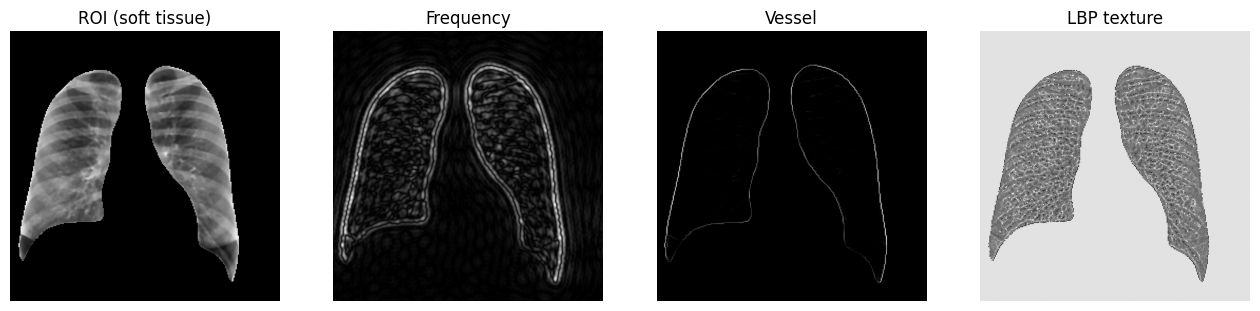

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# LOAD YOUR NPY FILE HERE
x = np.load(r"C:\Users\HP\Documents\processedCOVID-19_Radiography_Dataset\train\0\Normal-7608.npy")
print("Shape:", x.shape)     # should be (512, 512, 4)

# Plot all 4 channels
fig, axs = plt.subplots(1,4, figsize=(16,4))
titles = ["ROI (soft tissue)", "Frequency", "Vessel", "LBP texture"]

for i in range(4):
    axs[i].imshow(x[:,:,i], cmap='gray')
    axs[i].set_title(titles[i])
    axs[i].axis("off")

plt.show()
